In [2]:
!pip install prophet

     |████████████████████████████████| 71kB 5.2MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 184kB 8.9MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6640152 sha256=32398ff32ed7d4aa967d22ed7a52ec8f1e2c72247068da40f99bffb454cfbeca
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Apr 24 13:15:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd drive/MyDrive/Colab\ Notebooks/capstone3

/content/drive/MyDrive/Colab Notebooks/capstone3


In [6]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
keras = tf.keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

%matplotlib inline

from src.time_series_functions import *

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
print(keras.__version__)
##may need to update keras

2.4.0


In [8]:
def csv_with_datetime(filepath, col_name): 
    '''reads in a csv and converts specified column to datetime format and lablel ds
    and sets index to datetime'''
    df = pd.read_csv(filepath)
    df['ds'] = pd.to_datetime(df[col_name])
    df.set_index(pd.to_datetime(df[col_name]), inplace=True)
    df.drop(col_name, axis=1, inplace=True)
    return df

In [11]:
pwd


'/content/drive/My Drive/Colab Notebooks/capstone3'

In [12]:
base_df = csv_with_datetime('data/combdf_snoflow_and_cfs1.csv.zip', 'Unnamed: 0')
df = base_df.copy()

In [13]:
#small % of records containing NaNs in the temp columns, randomly distributed. using ffill. 
df.fillna(method='ffill', inplace=True)

In [14]:
df = df[['ds', 'Streamflow Value', 'Air Temperature Average (degF)',\
                'Precipitation Accumulation (in) Start of Day Values',\
                'Snow Water Equivalent (in) Start of Day Values']]

In [15]:
df.columns = ['ds', 'y', 'avg_temp', 'precip_accum', 'swe']

In [16]:
#cleaning the dataframe to end at 12/31/2020 for cleaner working frame

In [17]:
df = df['1990':'2020']

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1990-01-01 to 2020-12-31
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            11323 non-null  datetime64[ns]
 1   y             11323 non-null  float64       
 2   avg_temp      11323 non-null  float64       
 3   precip_accum  11323 non-null  float64       
 4   swe           11323 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 530.8 KB


In [19]:
#we now have a full 31 year dataframe (01/01/1990 - 12/31/2020), no nans, and columns appropriately named
#granularity of the data is daily, writing code based on day count not calendar year for OOP

In [20]:
#for generating graph only. train test split will happen after windowizing
test_size = 365 #days
#slice the training data to all years but final year
train = df.iloc[:-test_size,:].copy()
#slice the test data to final year
test = df.iloc[-test_size: , : ].copy()
#splitting training data into X_train and y_train, still dataframes maintaining their datetime index
X_train = train.drop(columns='y')
y_train = pd.DataFrame(train['y'])
X_test = test.drop(columns='y')
y_test = pd.DataFrame(train['y'])

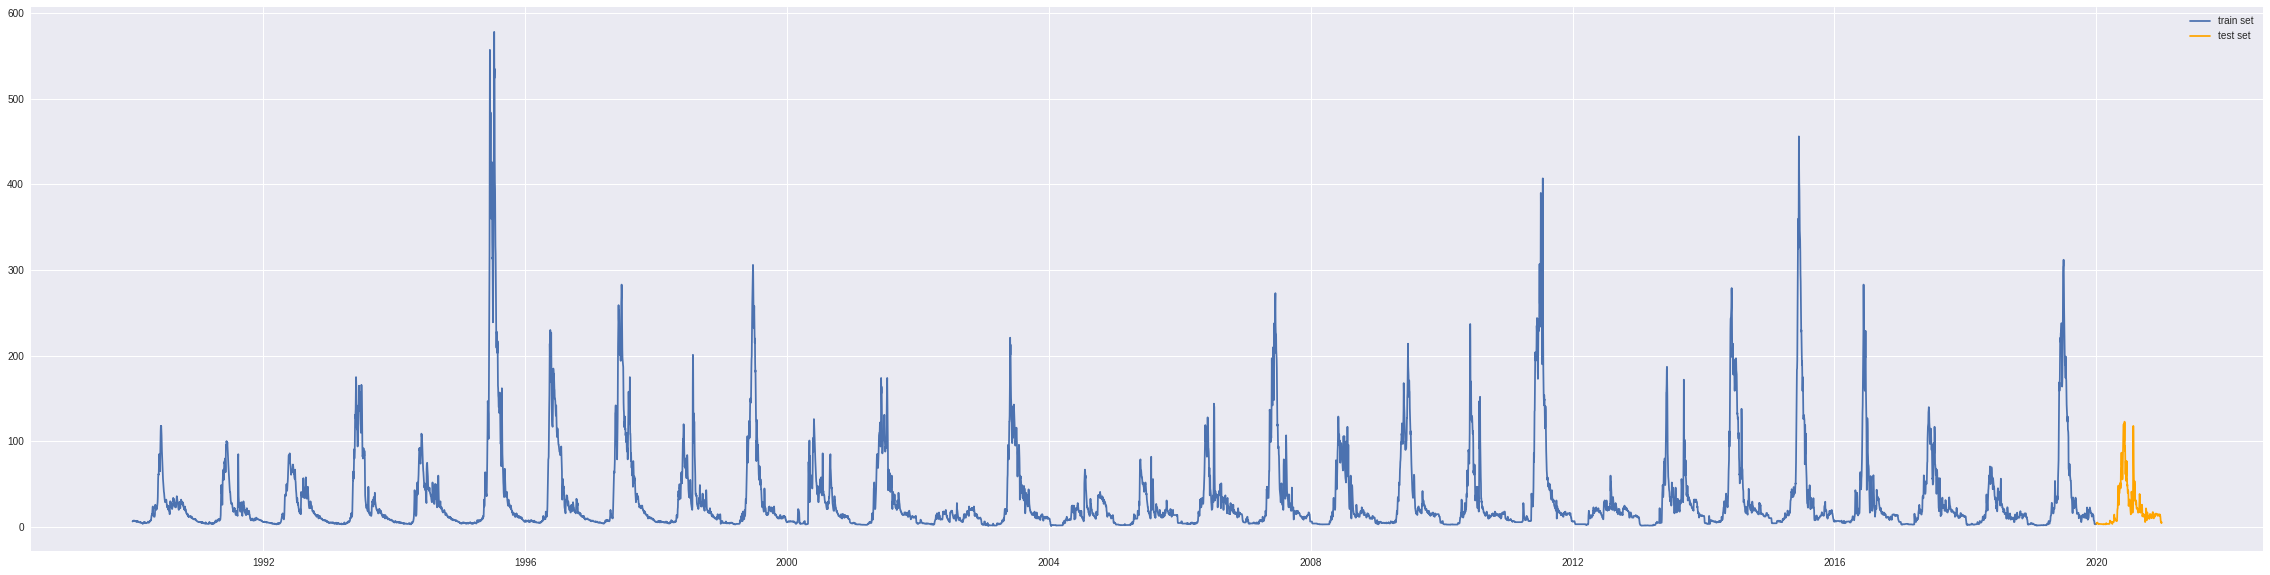

In [21]:
plt.figure(figsize=(40,10))
plt.plot(train.index,train['y'],label='train set');
plt.plot(test.index,test['y'],label='test set', color='orange')
plt.legend();

In [ ]:
#definitely out of proportion for normal train/test.  Prophet model did best passing only 20 years of training data
#will try different sizes of training data on LSTM to find optimal training set

In [22]:
#windowize function, three dimensional output for X and y, split afterwards
#the below windowize functions are imported but pasted here for working through setup
def windowize_data(data, n_prev, y_var='y', predict_steps=365):
    n_predictions = len(data) - n_prev
    y = data[y_var].iloc[n_prev:].values
    y_indices = np.arange(predict_steps) + np.arange(len(y) - predict_steps+1)[:, None]
    y = y[y_indices]
    x_indices = np.arange(n_prev) + np.arange(n_predictions- predict_steps+1)[:, None]
    x = data.values[x_indices]
    return x, y

In [81]:
# samp_df = df.iloc[-6000:, :].copy()
# n_prev = 400
# predict_steps = 30
# test_size = 365

In [170]:
samp_df = df.iloc[-6000:, :].copy()
n_prev = 120
predict_steps = 14
test_size = 365

In [171]:
#convert ds column to integer day number, continuous across entire dataframe
samp_df['ds'] = pd.to_datetime(df['ds']).sub(pd.Timestamp(df['ds'].iloc[0])).dt.days

In [172]:
from sklearn.preprocessing import StandardScaler

scale_df = samp_df.copy()
for column in scale_df.columns:
  if column != 'y':
    scaler = StandardScaler()
    # print (scale_df[column].values.shape)
    holder = scaler.fit_transform(scale_df[column].values.reshape(-1,1))
    scale_df[column] = holder.reshape(len(scale_df),)

In [173]:
scale_df.head()

,ds,y,avg_temp,precip_accum,swe
Unnamed: 0,,,,,
2004-07-29,-1.731762,33.0,1.050907,0.487837,-0.931964
2004-07-30,-1.731185,28.0,0.914353,0.508494,-0.931964
2004-07-31,-1.730607,26.0,1.392292,0.508494,-0.931964
2004-08-01,-1.730030,23.0,1.324015,0.508494,-0.931964
2004-08-02,-1.729453,24.0,1.119184,0.508494,-0.931964


In [174]:
scale_df.tail()

,ds,y,avg_temp,precip_accum,swe
Unnamed: 0,,,,,
2020-12-27,1.729453,6.23,-1.407062,-1.113107,-0.203519
2020-12-28,1.730030,5.80,-1.407062,-1.102778,-0.188343
2020-12-29,1.730607,4.99,-1.680170,-1.061463,-0.127640
2020-12-30,1.731185,4.48,-1.885000,-1.061463,-0.127640
2020-12-31,1.731762,5.62,-1.202231,-1.051135,-0.112464


In [175]:
X, y = windowize_data(scale_df, n_prev, 'y', predict_steps)

In [176]:
X_train = X[:-test_size]
X_test = X[-test_size:]

y_train = y[:-test_size]
y_test = y[-test_size:]

In [177]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5502, 120, 5), (365, 120, 5), (5502, 14), (365, 14))

In [178]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
callback = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 50,
                          verbose = 2,
                          restore_best_weights = True)

# checkpoint = ModelCheckpoint('checkpoints', monitor='val_loss', save_weights_only=True, save_best_only=True)

In [179]:
# model = keras.Sequential()
# model.add(keras.layers.LSTM(32, input_shape=(n_prev, 5), return_sequences=True))
# model.add(keras.layers.LSTM(32, return_sequences=False))
# model.add(keras.layers.Dense(predict_steps, activation='linear'))
# model.compile(optimizer='adam',
#               loss='mse')

In [180]:
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=30, kernel_size=3, input_shape=(None, 5)))
model.add(keras.layers.LSTM(32, return_sequences=True))
model.add(keras.layers.Conv1D(filters=30, kernel_size=3, input_shape=(None, 5)))
model.add(keras.layers.LSTM(32, return_sequences=False))
model.add(keras.layers.Dense(predict_steps, activation='linear'))
model.compile(optimizer='adam',
              loss='mse')

In [181]:
history = model.fit(X_train, y_train, batch_size=32, epochs=1000, validation_split=0.2, verbose=2, callbacks=[callback])
model.save('LSTM_v13.h5')

Epoch 1/1000
138/138 - 5s - loss: 3366.9229 - val_loss: 2568.2202
Epoch 2/1000
138/138 - 1s - loss: 3094.2065 - val_loss: 2378.4604
Epoch 3/1000
138/138 - 1s - loss: 2898.8850 - val_loss: 2224.4424
Epoch 4/1000
138/138 - 1s - loss: 2738.7766 - val_loss: 2095.7671
Epoch 5/1000
138/138 - 1s - loss: 2602.0452 - val_loss: 1982.0784
Epoch 6/1000
138/138 - 1s - loss: 2480.1602 - val_loss: 1880.8483
Epoch 7/1000
138/138 - 1s - loss: 2369.4758 - val_loss: 1790.4999
Epoch 8/1000
138/138 - 1s - loss: 2268.5676 - val_loss: 1706.3699
Epoch 9/1000
138/138 - 1s - loss: 2172.2271 - val_loss: 1629.6973
Epoch 10/1000
138/138 - 1s - loss: 2086.7986 - val_loss: 1556.3309
Epoch 11/1000
138/138 - 1s - loss: 2004.8335 - val_loss: 1495.5591
Epoch 12/1000
138/138 - 1s - loss: 1928.6962 - val_loss: 1428.2955
Epoch 13/1000
138/138 - 1s - loss: 1858.6812 - val_loss: 1368.4866
Epoch 14/1000
138/138 - 1s - loss: 1789.2926 - val_loss: 1322.7032
Epoch 15/1000
138/138 - 1s - loss: 1724.0170 - val_loss: 1268.1252
Epoc

In [182]:
y_pred = model.predict(X_test)

In [183]:
from keras.metrics import MeanAbsolutePercentageError
mape = tf.keras.metrics.MeanAbsolutePercentageError()
mape.update_state(y_test, y_pred)
mape.result().numpy()

35.6514

In [184]:
#RMSE
sqrt(mean_squared_error(y_test, y_pred))

14.08067363188518

In [257]:
# model.save('LSTM_v8.h5')

In [99]:
# y_pred

In [100]:
# X, X_train, X_test

In [101]:
# y, y_train, y_test

In [102]:
# y_test, y_pred